In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pymc as pm
import tensorflow_probability.substrates.jax as tfp
import preliz as pz
import arviz as az
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sympy as sp
tfd = tfp.distributions
tfb = tfp.bijectors

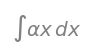

In [7]:
sp.init_printing(use_latex=True)
a, x = sp.symbols(r'\alpha x')
sp.Integral(a*x, x)

In [3]:
pz.BetaBinomial(alpha=10, beta=10, n=6).plot_interactive()

interactive(children=(FloatSlider(value=10.0, description='alpha (0, inf)', max=110.0, min=2.220446049250313e-…

In [8]:
model = tfd.JointDistributionSequentialAutoBatched(
    [
        tfd.FiniteDiscrete(outcomes=[1, 2, 3, 4], probs=[1, 1, 1, 1], name='x'),
        tfd.FiniteDiscrete(outcomes=[1, 2, 3, 4, 5, 6], probs=[1, 1, 1, 1, 1, 1], name='y'),
        lambda y, x: tfd.Deterministic(loc=x+y, name='z')
    ]
)

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1744967500.075067 1146669 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1744967500.103844 1146669 service.cc:145] XLA service 0x600001ebe900 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744967500.103857 1146669 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1744967500.105019 1146669 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1744967500.105031 1146669 mps_client.cc:384] XLA backend will use up to 11452858368 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2


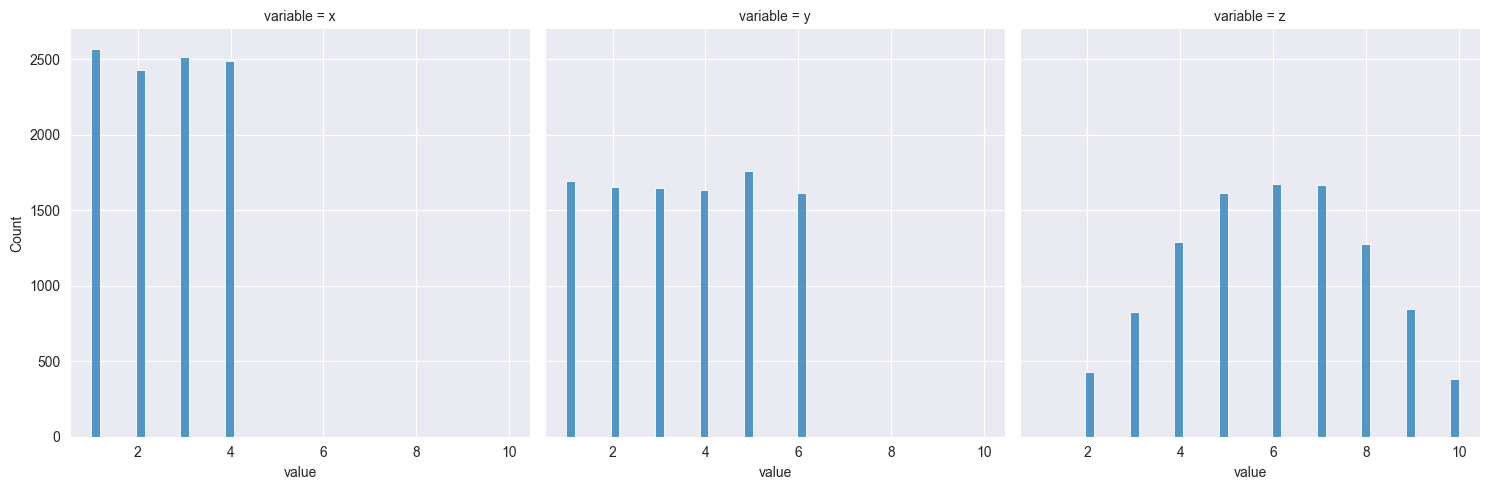

In [13]:
rng_key = jax.random.PRNGKey(42)
df = pd.DataFrame([np.asarray(x) for x in model.sample(10000, rng_key)], index=['x', 'y', 'z']).T
# Melt -> equivalent to marginalizing over each variable?  We lose the correlation structure
sns.displot(data=pd.melt(df), x='value', col='variable')
plt.show()


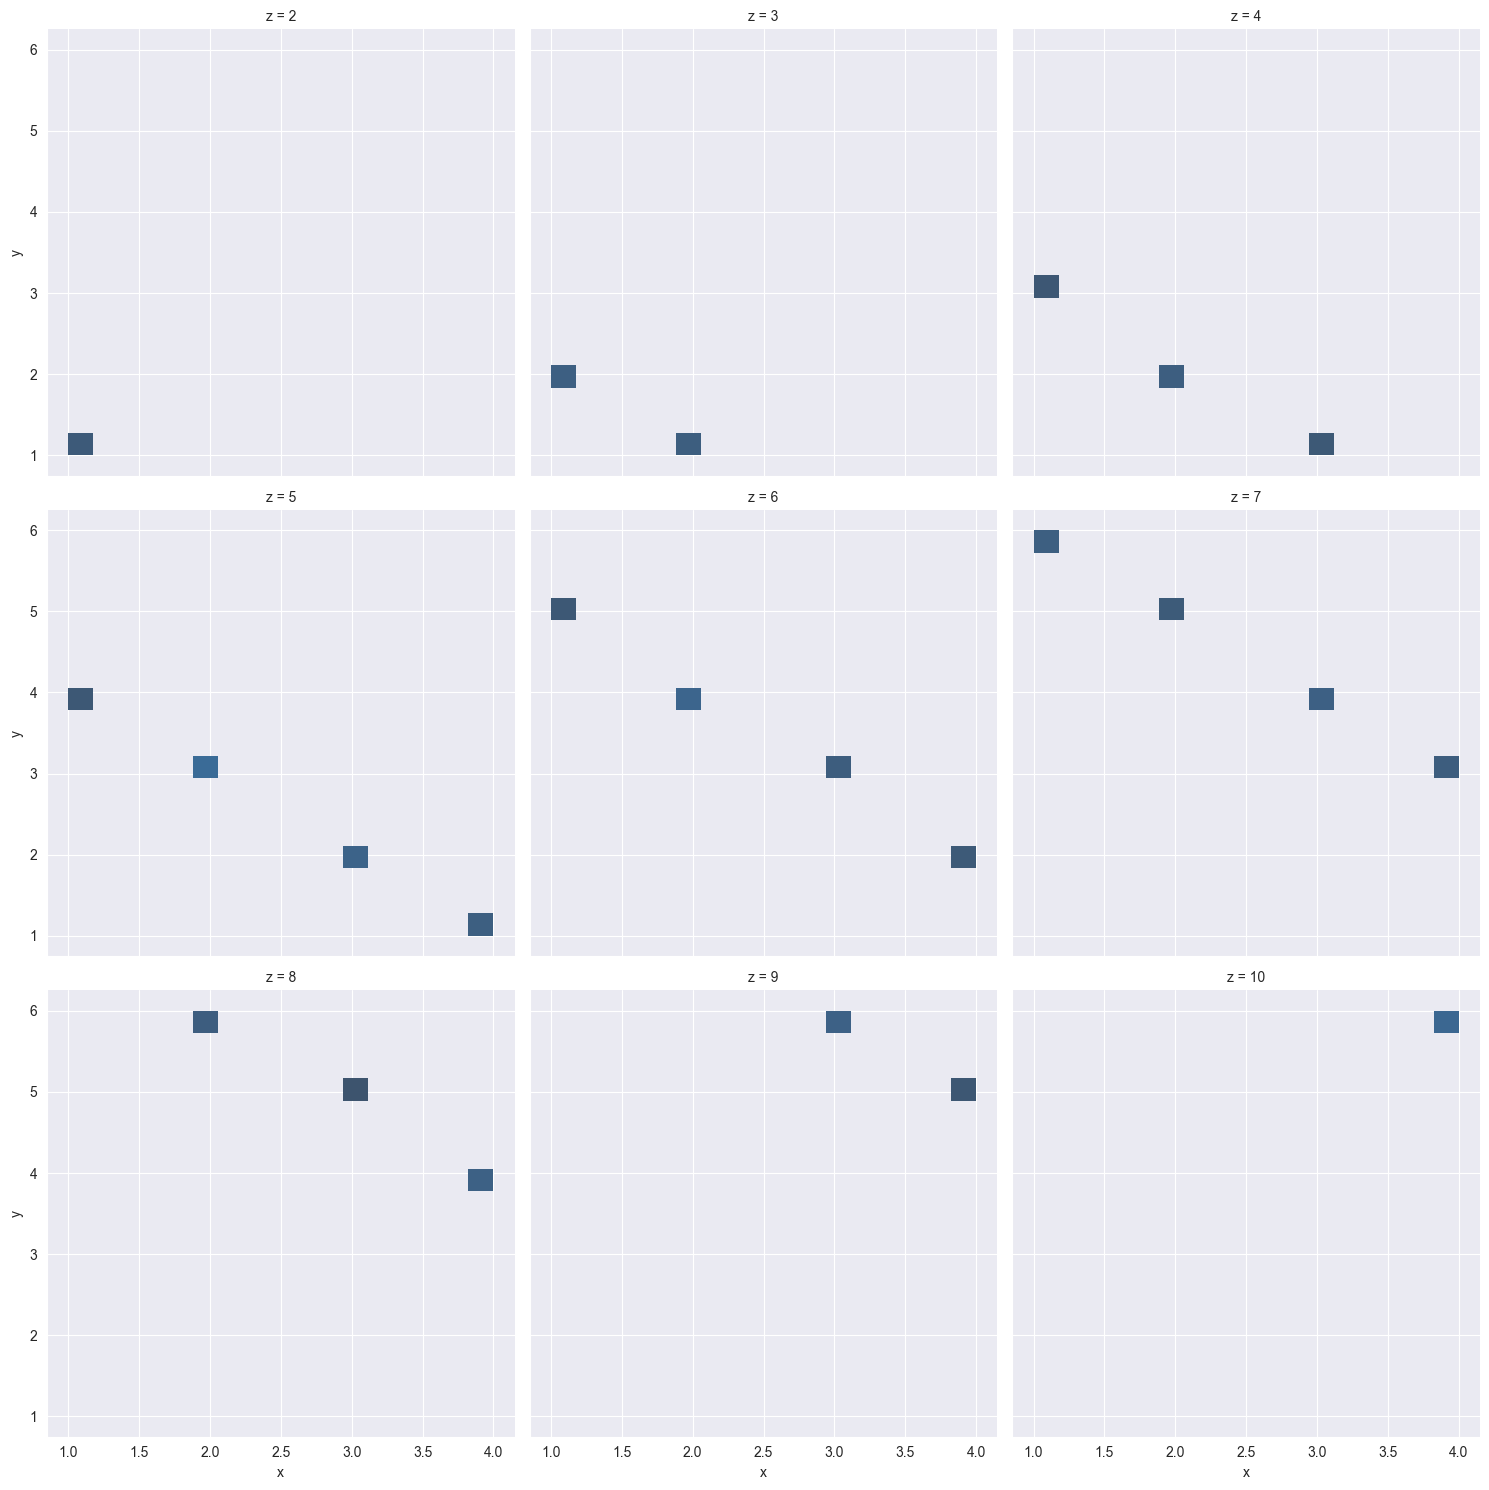

In [43]:
sns.displot(data=df.astype(int), x='x', y='y', col='z', col_wrap=3)
plt.show()

In [32]:
df.corr()

,x,y,z
x,1.000000,-0.006750,0.545568
y,-0.006750,1.000000,0.834365
z,0.545568,0.834365,1.000000


In [18]:
df.query('z == 6')[['x', 'y']]

,x,y
5,4.0,2.0
7,1.0,5.0
10,3.0,3.0
13,1.0,5.0
15,4.0,2.0
...,...,...
9971,1.0,5.0
9980,1.0,5.0
9983,3.0,3.0
9986,1.0,5.0


In [50]:
with pm.Model() as pm_model:
    x = pm.DiscreteUniform('x', 1, 4)
    y = pm.DiscreteUniform('y', 1, 6)
    z = pm.Deterministic('z', x + y)

In [57]:
pd.DataFrame(pm.draw([x,y, z], draws=1000, random_seed=42), index=['x', 'y', 'z']).T

,x,y,z
0,2,1,3
1,4,3,7
2,3,2,5
3,4,1,5
4,1,4,5
...,...,...,...
995,2,3,5
996,2,3,5
997,1,6,7
998,1,2,3


In [80]:
# Flip a coin, choose a dice
with pm.Model() as coin_dice:
    coin = pm.Bernoulli('coin', p=0.5)
    dice = pm.math.switch(coin < 0.5, pm.DiscreteUniform('d4', 1, 4), pm.DiscreteUniform('d6', 1, 6))

In [81]:
pm.draw([coin, dice], draws=10, random_seed=42)

[array([1, 1, 1, 0, 1, 0, 1, 1, 0, 0]), array([5, 1, 5, 1, 1, 3, 2, 2, 3, 4])]

In [78]:
# TFP flip a coin, choose a dice
tfp_coin_dice = tfd.JointDistributionSequentialAutoBatched(
    [
        tfd.Bernoulli(probs=0.5, name='coin', dtype=jnp.float32),
        lambda c: tfd.Mixture(
            cat=tfd.Categorical(probs=[1-c, c]),
            components=[
                tfd.FiniteDiscrete(outcomes=[1, 2, 3, 4], probs=[1, 1, 1, 1], name='d4'),
                tfd.FiniteDiscrete(outcomes=[1, 2, 3, 4, 5, 6], probs=[1, 1, 1, 1, 1, 1], name='d6')
            ]
        )
    ]
)

In [79]:
tfp_coin_dice.sample(10, rng_key)

[Array([0., 0., 1., 0., 1., 1., 1., 0., 0., 1.], dtype=float32),
 Array([4., 1., 1., 2., 2., 3., 2., 4., 3., 6.], dtype=float32)]